In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
random_forest_db = pd.read_csv('df_with_transformed_time.csv', index_col=False)

In [3]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)

In [4]:
X = random_forest_db.values[:, [1,2,3,4,5,6,7,8,9,10]]
Y = random_forest_db.values[:, 0]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,  random_state = 1)

In [6]:
clf = classifier.fit(X_train, y_train)

In [7]:
predictions = clf.predict(X_test)

In [8]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       green       0.81      0.95      0.88   1316493
         red       0.73      0.46      0.56    345387
      yellow       0.58      0.24      0.34    176120

    accuracy                           0.79   1838000
   macro avg       0.71      0.55      0.59   1838000
weighted avg       0.77      0.79      0.77   1838000



In [9]:
X1 = random_forest_db.values[:, [1,2,3,4,5,6,7,9,10]]
Y1 = random_forest_db.values[:, 0]

In [10]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size = 0.3, random_state = 1)

In [11]:
clf1 = classifier.fit(X1_train, y1_train)

In [12]:
predictions1 = clf1.predict(X1_test)

In [13]:
print(metrics.classification_report(y1_test, predictions1))

              precision    recall  f1-score   support

       green       0.84      0.93      0.88   1316493
         red       0.70      0.56      0.62    345387
      yellow       0.44      0.26      0.33    176120

    accuracy                           0.80   1838000
   macro avg       0.66      0.58      0.61   1838000
weighted avg       0.78      0.80      0.78   1838000



In [14]:
balanced_df = random_forest_db.groupby('landing_safety')
balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

In [15]:
X2 = balanced_df.values[:, [1,2,3,4,5,6,7,9,10]]
Y2 = balanced_df.values[:, 0]

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.3, random_state = 1)

In [17]:
clf2 = classifier.fit(X2_train, y2_train)

In [18]:
predictions2 = clf2.predict(X2_test)

In [19]:
print(metrics.classification_report(y2_test, predictions2))

              precision    recall  f1-score   support

       green       0.58      0.63      0.60    177027
         red       0.66      0.66      0.66    176776
      yellow       0.61      0.56      0.58    176622

    accuracy                           0.61    530425
   macro avg       0.62      0.61      0.61    530425
weighted avg       0.62      0.61      0.61    530425



In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
import numpy as np

In [22]:
def run_cross_validation_on_forest(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        forest_model = RandomForestClassifier(max_depth=depth)
        cv_scores = cross_val_score(forest_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(forest_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [23]:
sm_tree_depths = range(5,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X1_train, y1_train, sm_tree_depths)

In [24]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset for random forest'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-14 tree achieves the best mean cross-validation accuracy 74.83441 +/- 0.03514% on training dataset for random forest


In [25]:
clf3 = RandomForestClassifier(sm_best_tree_depth).fit(X1_train, y1_train)

In [26]:
predictions3 = clf3.predict(X1_test)

In [27]:
print(metrics.classification_report(y1_test, predictions3))

              precision    recall  f1-score   support

       green       0.84      0.93      0.88   1316493
         red       0.71      0.57      0.63    345387
      yellow       0.45      0.27      0.33    176120

    accuracy                           0.80   1838000
   macro avg       0.67      0.59      0.62   1838000
weighted avg       0.78      0.80      0.78   1838000



In [28]:
import matplotlib.pyplot as plt

In [29]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

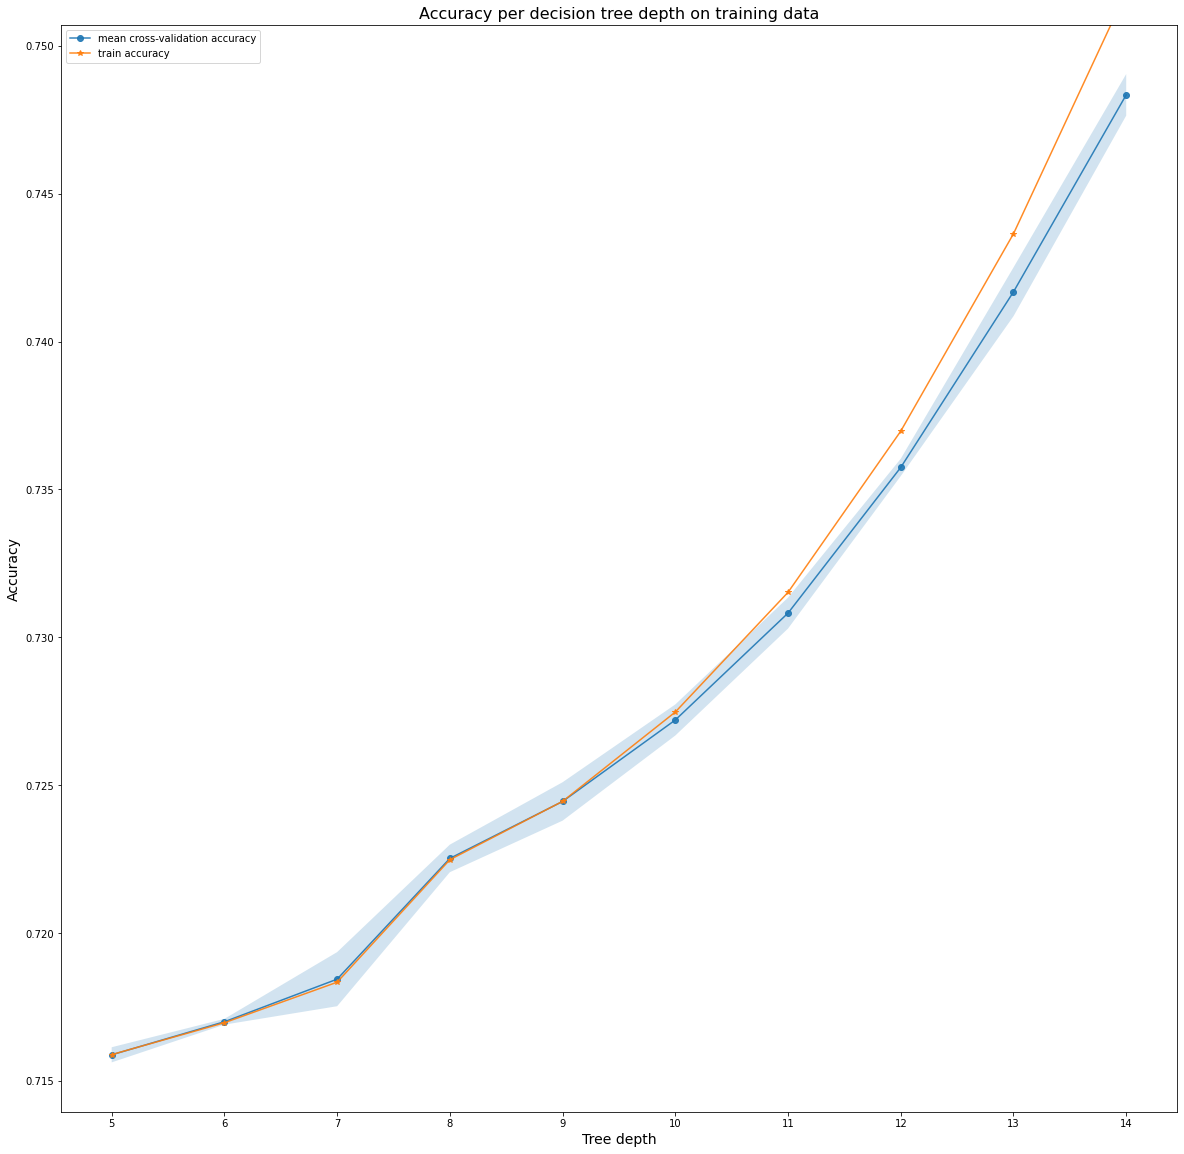

In [30]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [31]:
sm_tree_depths = range(15,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X1_train, y1_train, sm_tree_depths)

In [32]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset for random forest'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-24 tree achieves the best mean cross-validation accuracy 81.24198 +/- 0.01639% on training dataset for random forest


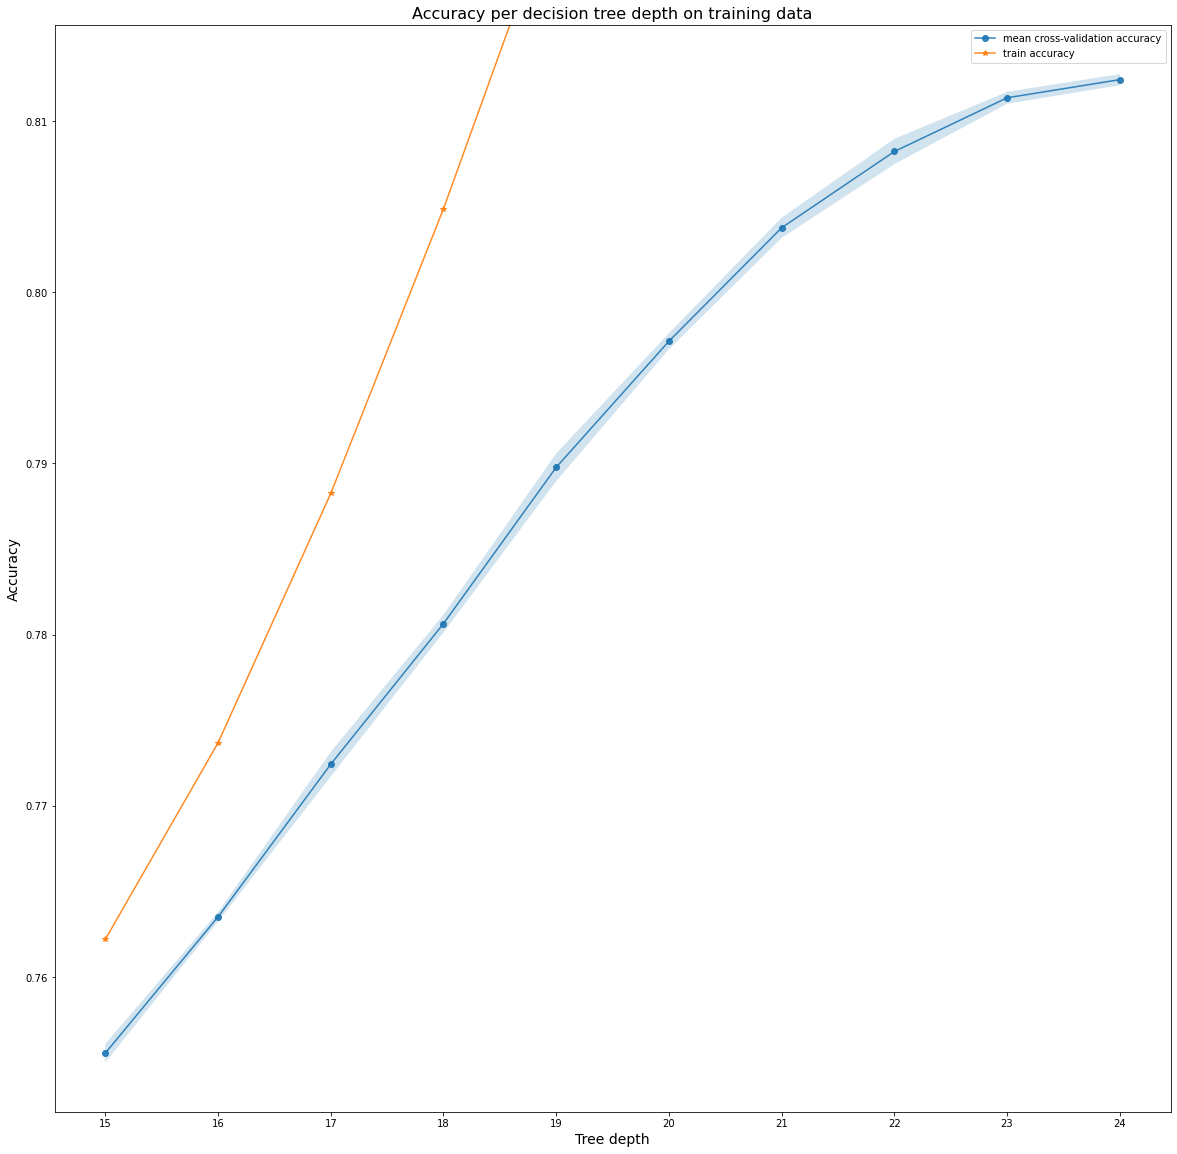

In [33]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [34]:
clf4 = RandomForestClassifier(sm_best_tree_depth).fit(X1_train, y1_train)

In [35]:
predictions4 = clf4.predict(X1_test)

In [36]:
print(metrics.classification_report(y1_test, predictions4))

              precision    recall  f1-score   support

       green       0.84      0.93      0.89   1316493
         red       0.71      0.58      0.64    345387
      yellow       0.46      0.27      0.34    176120

    accuracy                           0.80   1838000
   macro avg       0.67      0.59      0.62   1838000
weighted avg       0.78      0.80      0.79   1838000



In [37]:
clf5 = RandomForestClassifier(25).fit(X1_train, y1_train)

In [38]:
predictions5 = clf5.predict(X1_test)

In [39]:
print(metrics.classification_report(y1_test, predictions5))

              precision    recall  f1-score   support

       green       0.84      0.93      0.89   1316493
         red       0.71      0.58      0.64    345387
      yellow       0.46      0.27      0.34    176120

    accuracy                           0.80   1838000
   macro avg       0.67      0.59      0.62   1838000
weighted avg       0.78      0.80      0.79   1838000



In [65]:
importance1 = clf.feature_importances_

In [41]:
importance2 = clf1.feature_importances_

In [42]:
importance3 = clf2.feature_importances_

In [43]:
importance4 = clf3.feature_importances_

In [44]:
importance5 = clf4.feature_importances_

In [45]:
importance6 = clf5.feature_importances_

In [66]:
for i,v in enumerate(importance1):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.05618
Feature: 1, Score: 0.04020
Feature: 2, Score: 0.03802
Feature: 3, Score: 0.12404
Feature: 4, Score: 0.10621
Feature: 5, Score: 0.06595
Feature: 6, Score: 0.07382
Feature: 7, Score: 0.24046
Feature: 8, Score: 0.25511


In [47]:
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.05618
Feature: 1, Score: 0.04020
Feature: 2, Score: 0.03802
Feature: 3, Score: 0.12404
Feature: 4, Score: 0.10621
Feature: 5, Score: 0.06595
Feature: 6, Score: 0.07382
Feature: 7, Score: 0.24046
Feature: 8, Score: 0.25511


In [48]:
for i,v in enumerate(importance3):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.05618
Feature: 1, Score: 0.04020
Feature: 2, Score: 0.03802
Feature: 3, Score: 0.12404
Feature: 4, Score: 0.10621
Feature: 5, Score: 0.06595
Feature: 6, Score: 0.07382
Feature: 7, Score: 0.24046
Feature: 8, Score: 0.25511


In [49]:
for i,v in enumerate(importance4):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06381
Feature: 1, Score: 0.03840
Feature: 2, Score: 0.03542
Feature: 3, Score: 0.12215
Feature: 4, Score: 0.10055
Feature: 5, Score: 0.06018
Feature: 6, Score: 0.05557
Feature: 7, Score: 0.25538
Feature: 8, Score: 0.26853


In [50]:
for i,v in enumerate(importance5):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06271
Feature: 1, Score: 0.03734
Feature: 2, Score: 0.03389
Feature: 3, Score: 0.12198
Feature: 4, Score: 0.10031
Feature: 5, Score: 0.05948
Feature: 6, Score: 0.05526
Feature: 7, Score: 0.25635
Feature: 8, Score: 0.27268


In [51]:
for i,v in enumerate(importance6):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06257
Feature: 1, Score: 0.03732
Feature: 2, Score: 0.03632
Feature: 3, Score: 0.12246
Feature: 4, Score: 0.10099
Feature: 5, Score: 0.05749
Feature: 6, Score: 0.05425
Feature: 7, Score: 0.25507
Feature: 8, Score: 0.27352


In [52]:
import matplotlib

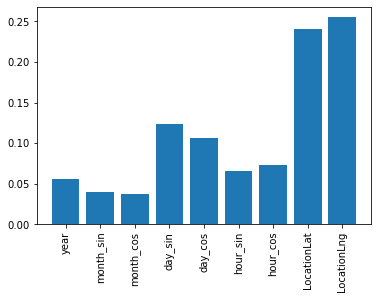

In [98]:
plt.bar([x for x in range(len(importance1))], importance1)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()

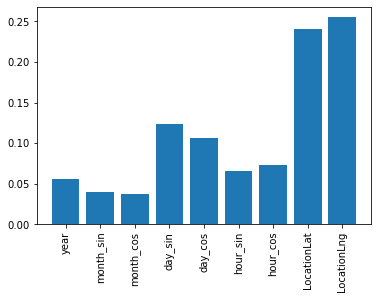

In [60]:
plt.bar([x for x in range(len(importance2))], importance2)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()

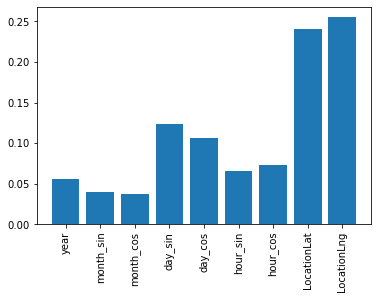

In [61]:
plt.bar([x for x in range(len(importance3))], importance3)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()

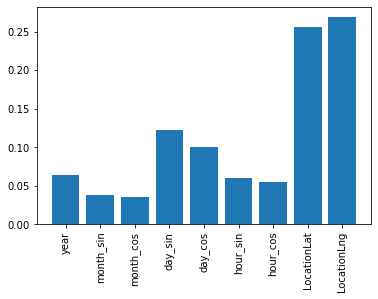

In [62]:
plt.bar([x for x in range(len(importance4))], importance4)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()

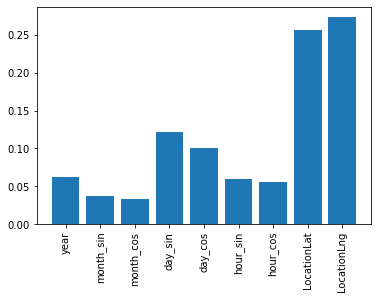

In [63]:
plt.bar([x for x in range(len(importance5))], importance5)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()

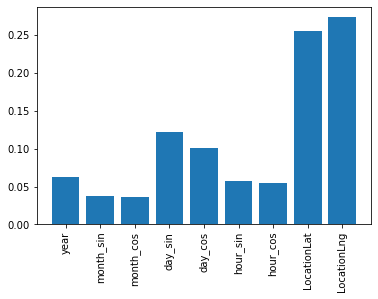

In [64]:
plt.bar([x for x in range(len(importance6))], importance6)
ax=plt.subplot()
ax.set_xticks(np.arange(0, 9, 1))
labels = random_forest_db.columns[1::].values.tolist()
labels.remove('durationInSeconds')
ax.set_xticklabels(labels , rotation = 90)
plt.show()